In [18]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

# TCGA RNA-seq analysis pipeline with enrichment analysis from Enrichr 
---

In [160]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from maayanlab_bioinformatics.dge import characteristic_direction
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var, zscore_normalize
from maayanlab_bioinformatics.utils import merge
import plotly.express as px
import math
import s3fs
import logging
from botocore.exceptions import ClientError
from collections import OrderedDict
from ipywidgets import interact,widgets

In [10]:
%%appyter hide_code

{% do SectionField(
    name="DATASET",
    title="Dataset selection",
    img = "tcga-logo.png"
) %}


{% do SectionField(
    name='CONFIG',
    title='Analysis parameters',
    img = "cluster-icon.svg"

) %}

{% do SectionField(
    name="ENRICHR_LIBS",
    title="Libraries to include in the Enrichr search",
    img = "enrichr-logo.png"


) %}

UsageError: Cell magic `%%appyter` not found.


In [ ]:
%%appyter code_eval

cancer = "{{ChoiceField(
    name = "cancer",
    label = "Cancer type",
    description="The value provided as the primary diagnosis on cases in TCGA.",
    choices=["Adrenal cortical carcinoma","Papillary adenocarcinoma, NOS","Serous cystadenocarcinoma, NOS"],
    section="DATASET",
    default="Serous cystadenocarcinoma, NOS" ) }}"

    
# Dimensionality reduction parameters

n_pca_components = {{IntField(
    name='n_pca_components',
    label='Number of PCA components to use for UMAP',
    description='The number of \'top\' PCA components to use for further dimensionality reduction using the UMAP algorithm',
    default=10,
    min=0,
    max=100,
    section='CONFIG',
)}}

n_neighbors = {{IntField(
    name='n_neighbors',
    label='Number of neighbors for each projected datapoint computed by UMAP',
    description='Smaller values preserve local manifold structure in the dataset as opposed to overall global structure',
    default=2,
    min=2,
    max=20,
    section='CONFIG',
)}}

min_cluster_dist = {{FloatField(
    name='min_cluster_dist',
    label='Minimum distance between UMAP-projected points',
    description='How tightly packed points produced by dimensionality reduction with UMAP are permitted to be.',
    default=0.3,
    min=0.1,
    max=1,
    section='CONFIG',
)}}


# The number of 'top' genes to use for differential expression
top_n_genes = {{IntField(
    name='top_n_genes',
    label='Number of Genes',
    description='The number of \'top\' genes to use for differential expression',
    default=250,
    min=100,
    max=1000,
    section='CONFIG',
)}}

# The number of 'top' results to keep from enrichment analysis
top_n_results = {{ IntField(
    name='top_n_results',
    label='Number of Top Enrichment Results',
    description='The number of \'top\' results to keep from enrichment analysis',
    default=5,
    min=1,
    max=100,
    section='CONFIG',
)}}

transcription_libraries = {{ MultiChoiceField(name='transcription_libraries', 
                                              description='Select the Enrichr libraries you would like in your figure.', 
                                              label='Transcription', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[
                                                    'ARCHS4_TFs_Coexp',
                                                    'ChEA_2016',
                                                    'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
                                                    'ENCODE_Histone_Modifications_2015',
                                                    'ENCODE_TF_ChIP-seq_2015',
                                                    'Epigenomics_Roadmap_HM_ChIP-seq',
                                                    'Enrichr_Submissions_TF-Gene_Coocurrence',
                                                    'Genome_Browser_PWMs',
                                                    'lncHUB_lncRNA_Co-Expression',
                                                    'miRTarBase_2017',
                                                    'TargetScan_microRNA_2017',
                                                    'TF-LOF_Expression_from_GEO',
                                                    'TF_Perturbations_Followed_by_Expression',
                                                    'Transcription_Factor_PPIs',
                                                    'TRANSFAC_and_JASPAR_PWMs',
                                                    'TRRUST_Transcription_Factors_2019'
                                                ]) }}

pathways_libraries = {{ MultiChoiceField(name='pathways_libraries', 
                                         description='Select the Enrichr libraries you would like in your figure.', 
                                         label='Pathways', 
                                         default=[], 
                                         section='ENRICHR_LIBS',
                                         choices=[
                                                    'ARCHS4_Kinases_Coexp',
                                                    'BioCarta_2016',
                                                    'BioPlanet_2019',
                                                    'BioPlex_2017',
                                                    'CORUM',
                                                    'Elsevier_Pathway_Collection',
                                                    'HMS_LINCS_KinomeScan',
                                                    'HumanCyc_2016',
                                                    'huMAP',
                                                    'KEA_2015',
                                                    'KEGG_2019_Human',
                                                    'KEGG_2019_Mouse',
                                                    'Kinase_Perturbations_from_GEO_down',
                                                    'Kinase_Perturbations_from_GEO_up',
                                                    'L1000_Kinase_and_GPCR_Perturbations_down',
                                                    'L1000_Kinase_and_GPCR_Perturbations_up',
                                                    'NCI-Nature_2016',
                                                    'NURSA_Human_Endogenous_Complexome',
                                                    'Panther_2016',
                                                    'Phosphatase_Substrates_from_DEPOD',
                                                    'PPI_Hub_Proteins',
                                                    'Reactome_2016',
                                                    'SILAC_Phosphoproteomics',
                                                    'SubCell_BarCode',
                                                    'Virus-Host_PPI_P-HIPSTer_2020',
                                                    'WikiPathways_2019_Human',
                                                    'WikiPathways_2019_Mouse']) }} 

ontologies_libraries = {{ MultiChoiceField(name='ontologies_libraries', 
                                           description='Select the Enrichr libraries you would like in your figure.', 
                                           label='Ontologies', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[
                                                'GO_Biological_Process_2018',
                                                'GO_Cellular_Component_2018',
                                                'GO_Molecular_Function_2018',
                                                'Human_Phenotype_Ontology',
                                                'Jensen_COMPARTMENTS',
                                                'Jensen_DISEASES',
                                                'Jensen_TISSUES',
                                                'MGI_Mammalian_Phenotype_Level_4_2019'
                                           ]) }}
    
diseases_drugs_libraries = {{ MultiChoiceField(name='diseases_drugs_libraries', 
                                               description='Select the Enrichr libraries you would like in your figure.', 
                                               label='Diseases/Drugs', 
                                               default=[], 
                                               section = 'ENRICHR_LIBS',
                                               choices=[    
                                                    'Achilles_fitness_decrease',
                                                    'Achilles_fitness_increase',
                                                    'ARCHS4_IDG_Coexp',
                                                    'ClinVar_2019',
                                                    'dbGaP',
                                                    'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
                                                    'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
                                                    'DisGeNET',
                                                    'DrugMatrix',
                                                    'DSigDB',
                                                    'GeneSigDB',
                                                    'GWAS_Catalog_2019',
                                                    'LINCS_L1000_Chem_Pert_down',
                                                    'LINCS_L1000_Chem_Pert_up',
                                                    'LINCS_L1000_Ligand_Perturbations_down',
                                                    'LINCS_L1000_Ligand_Perturbations_up',
                                                    'MSigDB_Computational',
                                                    'MSigDB_Oncogenic_Signatures',
                                                    'Old_CMAP_down',
                                                    'Old_CMAP_up',
                                                    'OMIM_Disease',
                                                    'OMIM_Expanded',
                                                    'PheWeb_2019',
                                                    'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_AutoRIF_Gene_Lists',
                                                    'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_GeneRIF_Gene_Lists',
                                                    'UK_Biobank_GWAS_v1',
                                                    'Virus_Perturbations_from_GEO_down',
                                                    'Virus_Perturbations_from_GEO_up',
                                                    'VirusMINT']) }}
    
cell_types_libraries = {{ MultiChoiceField(name='cell_types_libraries', 
                                           description='Select the Enrichr libraries you would like in your figure.', 
                                           label='Cell Types', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[        
                                                'Allen_Brain_Atlas_down',
                                                'Allen_Brain_Atlas_up',
                                                'ARCHS4_Cell-lines',
                                                'ARCHS4_Tissues',
                                                'Cancer_Cell_Line_Encyclopedia',
                                                'CCLE_Proteomics_2020',
                                                'ESCAPE',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_down',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_up',
                                                'Human_Gene_Atlas',
                                                'Mouse_Gene_Atlas',
                                                'NCI-60_Cancer_Cell_Lines',
                                                'ProteomicsDB_2020',
                                                'Tissue_Protein_Expression_from_Human_Proteome_Map']) }}    
    
    
    
miscellaneous_libraries = {{ MultiChoiceField(name='miscellaneous_libraries', 
                                              description='Select the Enrichr libraries you would like in your figure.', 
                                              label='Miscellaneous', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[            
                                                    'Chromosome_Location_hg19',
                                                    'Data_Acquisition_Method_Most_Popular_Genes',
                                                    'Enrichr_Libraries_Most_Popular_Genes',
                                                    'Genes_Associated_with_NIH_Grants',
                                                    'HMDB_Metabolites',
                                                    'HomoloGene',
                                                    'InterPro_Domains_2019',
                                                    'NIH_Funded_PIs_2017_AutoRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_Human_AutoRIF',
                                                    'NIH_Funded_PIs_2017_Human_GeneRIF',
                                                    'Pfam_Domains_2019',
                                                    'Pfam_InterPro_Domains',
                                                    'Table_Mining_of_CRISPR_Studies']) }}    
    
    
legacy_libraries = {{ MultiChoiceField(name='legacy_libraries', 
                                       description='Select the Enrichr libraries you would like in your figure.', 
                                       label='Legacy', 
                                       default=[], 
                                       section = 'ENRICHR_LIBS',
                                       choices=[                
                                            'BioCarta_2013',
                                            'BioCarta_2015',
                                            'ChEA_2013',
                                            'ChEA_2015',
                                            'Chromosome_Location',
                                            'Disease_Signatures_from_GEO_down_2014',
                                            'Disease_Signatures_from_GEO_up_2014',
                                            'Drug_Perturbations_from_GEO_2014',
                                            'ENCODE_Histone_Modifications_2013',
                                            'ENCODE_TF_ChIP-seq_2014',
                                            'GO_Biological_Process_2013',
                                            'GO_Biological_Process_2015',
                                            'GO_Biological_Process_2017',
                                            'GO_Biological_Process_2017b',
                                            'GO_Cellular_Component_2013',
                                            'GO_Cellular_Component_2015',
                                            'GO_Cellular_Component_2017',
                                            'GO_Cellular_Component_2017b',
                                            'GO_Molecular_Function_2013',
                                            'GO_Molecular_Function_2015',
                                            'GO_Molecular_Function_2017',
                                            'GO_Molecular_Function_2017b',
                                            'HumanCyc_2015',
                                            'KEA_2013',
                                            'KEGG_2013',
                                            'KEGG_2015',
                                            'KEGG_2016',
                                            'MGI_Mammalian_Phenotype_2013',
                                            'MGI_Mammalian_Phenotype_2017',
                                            'MGI_Mammalian_Phenotype_Level_3',
                                            'MGI_Mammalian_Phenotype_Level_4',
                                            'NCI-Nature_2015',
                                            'Panther_2015',
                                            'Reactome_2013',
                                            'Reactome_2015',
                                            'TargetScan_microRNA',
                                            'Tissue_Protein_Expression_from_ProteomicsDB',
                                            'WikiPathways_2013',
                                            'WikiPathways_2015',
                                            'WikiPathways_2016']) }} 

crowd_libraries = {{ MultiChoiceField(name='crowd_libraries', 
                                      description='Select the Enrichr libraries you would like in your figure.', 
                                      label='Crowd', 
                                      default=[],
                                      section = 'ENRICHR_LIBS',
                                      choices=[                
                                            'Aging_Perturbations_from_GEO_down',
                                            'Aging_Perturbations_from_GEO_up',
                                            'Disease_Perturbations_from_GEO_down',
                                            'Disease_Perturbations_from_GEO_up',
                                            'Drug_Perturbations_from_GEO_down',
                                            'Drug_Perturbations_from_GEO_up',
                                            'Gene_Perturbations_from_GEO_down',
                                            'Gene_Perturbations_from_GEO_up',
                                            'Ligand_Perturbations_from_GEO_down',
                                            'Ligand_Perturbations_from_GEO_up',
                                            'MCF7_Perturbations_from_GEO_down',
                                            'MCF7_Perturbations_from_GEO_up',
                                            'Microbe_Perturbations_from_GEO_down',
                                            'Microbe_Perturbations_from_GEO_up',
                                            'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
                                            'SysMyo_Muscle_Gene_Sets']) }}

enrichr_libraries = OrderedDict([
    ('Diseases/Drugs', diseases_drugs_libraries), 
    ('Ontologies', ontologies_libraries),
    ('Cell Type', cell_types_libraries),
    ('Pathways', pathways_libraries),
    ('Transcription', transcription_libraries),
    ('Legacy', legacy_libraries),
    ('Crowd', crowd_libraries)
])

## Import dataset

We first download the data containing RNA-seq profiles for the selected cancer type from TCGA and the corresponding clinical data for those cases.

The RNA-seq data that is provided has already been processed using the HTSeq Python package, which calculates the number of mapped reads to each gene.

In [ ]:
# Utility function for saving the dataset

def save_data(cancer_type,
              df_data_norm_km,
              df_data_norm_pca,
              df_data_norm_umap,
              df_diff_expr,
              df_aucs):
    
    # create the root dir
    root_dir = f'./processed_data/{cancer_type}'
    os.makedirs(root_dir, exist_ok=True)

    # /clustering/graphclust/clusters.csv
    #   Barcode,Cluster
    os.makedirs(f'{root_dir}/clustering/graphclust', exist_ok=True)
    df_data_norm_km.to_csv(f'{root_dir}/clustering/graphclust/clusters.csv')
    
    # /pca/10_components/projection.csv
    #   Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
    os.makedirs(f'{root_dir}/pca/{n_pca_components}_components', exist_ok=True)
    df_data_norm_pca.to_csv(f'{root_dir}/pca/{n_pca_components}_components/projection.csv')
    
    # /umap/2_components/projection.csv
    #   Barcode,UMAP-1,UMAP-2
    os.makedirs(f'{root_dir}/umap/2_components', exist_ok=True)
    df_data_norm_umap.to_csv(f'{root_dir}/umap/2_components/projection.csv')
    
     # /diffexp/graphclust/differential_expression.csv
    #   Feature Name,Cluster 2 Log2 fold change,Cluster 0 Log2 fold change,Cluster 1 Log2 fold change,Cluster 3 Log2 fold change,Cluster 2 Adjusted p value,Cluster 0 Adjusted p value,Cluster 1 Adjusted p value,Cluster 3 Adjusted p value,Cluster 2 Mean Counts,Cluster 0 Mean Counts,Cluster 1 Mean Counts,Cluster 3 Mean Counts,Feature Name
    os.makedirs(f'{root_dir}/diffexp/graphclust', exist_ok=True)
    df_diff_expr.to_csv(f'{root_dir}/diffexp/graphclust/differential_expression.csv')
    
    # /cluster_aucs.csv
    #   ,2,0,1,3
    df_aucs.to_csv(f'{root_dir}/cluster_aucs.csv')

In [11]:
# Import the RNA-seq and clinical DataFrames with only entries corresponding 
# the selected cancer type

df_data = pd.read_csv(f's3://tcga-enrichr-viewer/{cancer}_data.csv')
df_data = df_data.set_index("symbol")

df_clinical = pd.read_csv(f's3://tcga-enrichr-viewer/{cancer}_clinical_data.csv')
df_clinical = df_clinical.set_index("case_id")
df_clinical = df_clinical.replace("not reported", np.nan)

In [164]:
# Get a list of the clinical features with multiple unique values

features = df_clinical.columns.values

def has_unique_values(feature):
    unique = df_clinical[feature].dropna().unique()
    if len(unique) >= 1: return True
    return False

features = list(filter(
    lambda x: x != "primary_diagnosis" and has_unique_values(x), features))

df_clinical = df_clinical[features]

print(f"{df_clinical.shape[0]} cases, {len(features)} features")

display(df_clinical.head())

,primary_diagnosis,primary_gleason_grade,figo_staging_edition_year,updated_datetime,occupation_duration_years,ann_arbor_clinical_stage,best_overall_response,largest_extrapelvic_peritoneal_focus,esophageal_columnar_dysplasia_degree,perineural_invasion_present,...,lymph_node_involved_site,year_of_diagnosis,ann_arbor_b_symptoms,gastric_esophageal_junction_involvement,days_to_birth,ajcc_clinical_stage,treatments,ajcc_pathologic_stage,progression_or_recurrence,ajcc_pathologic_t
case_id,,,,,,,,,,,,,,,,,,,,,
d79e692c-5053-4484-a180-01a094c5ff45,"Serous cystadenocarcinoma, NOS",NaN,NaN,2019-08-27T13:09:24.298212-05:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2010,NaN,NaN,-25612.0,NaN,NaN,NaN,NaN,NaN
32b5d0e4-a242-44d1-ac20-6e5ca2f35b71,"Serous cystadenocarcinoma, NOS",NaN,NaN,2019-08-27T13:11:28.180392-05:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2007,NaN,NaN,-23913.0,NaN,NaN,NaN,NaN,NaN
16e69011-c295-479f-b521-86e66fba498d,"Serous cystadenocarcinoma, NOS",NaN,NaN,2019-08-27T13:10:55.555572-05:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2008,NaN,NaN,-27065.0,NaN,NaN,NaN,NaN,NaN
211b2c52-1ad8-4d33-af0b-69ec1a56c821,"Serous cystadenocarcinoma, NOS",NaN,NaN,2019-08-27T13:08:19.563638-05:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2010,NaN,NaN,-20594.0,NaN,NaN,NaN,NaN,NaN
37d5c1d9-3ff5-44fe-afdc-ff430a0f3510,"Serous cystadenocarcinoma, NOS",NaN,NaN,2019-08-27T13:10:55.555572-05:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2010,NaN,NaN,-28037.0,NaN,NaN,NaN,NaN,NaN


## Process data and compute clusters

Next, we'll need to normalize the RNA-seq data, reduce its dimensionality using PCA and UMAP, and compute clusters of RNA-seq profiles.

In [165]:
# Data size stats

df_library_size = pd.DataFrame(
    {
        'n_reads': df_data[df_data > 0].count(),
        'log_n_reads': np.log2(df_data[df_data > 0].count() + 1),
        'n_expressed_genes': df_data.sum(),
    }).sort_values('n_reads', ascending=False)

df_library_size.index.name = "case_id"
display(df_library_size.head()) 

,n_reads,log_n_reads,n_expressed_genes
5d2f1a0f-a01b-48c2-b749-1ca710aa2bb4,18491,14.174614,22545956
548ec160-4183-459f-8393-f4b4672a3251,18042,14.139152,18567787
27920e1e-b9ab-4587-970a-0cba7025becb,17948,14.131616,50515515
ab7adf74-6e87-4117-9742-54e323348e06,17929,14.130088,20780221
ab7adf74-6e87-4117-9742-54e323348e06,17929,14.130088,20780221


In [166]:
# Normalization

# take 2500 top most variable rows
df_data_norm = filter_by_var(df_data)

# compute log normalization of matrix
df_data_norm = log2_normalize(df_data_norm)

# convert to zscores
df_data_norm = zscore_normalize(df_data_norm)

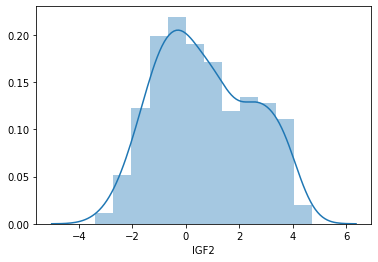

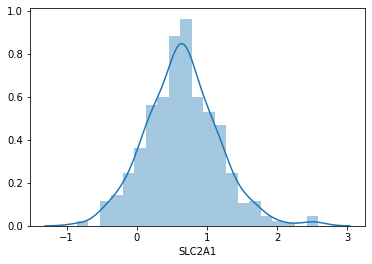

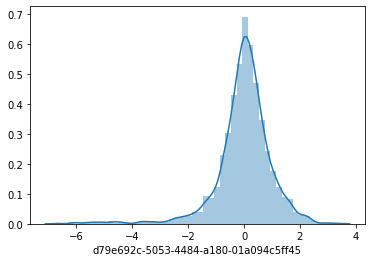

In [167]:
# plot 2 random gene distributions
sns.distplot(df_data_norm.iloc[0, :]); plt.show()
sns.distplot(df_data_norm.iloc[200, :]); plt.show()

# plot a single RNA seq profile distribution
sns.distplot(df_data_norm.iloc[:, 0]); plt.show()

We use PCA to initially reduce the dimensionality of the dataset before clustering while still maintaining most of the variability.

In [168]:
# PCA
data_norm_pca = PCA(
  random_state=42,
)

data_norm_pca.fit(df_data_norm.values.T)

df_data_norm_pca = pd.DataFrame(
    data_norm_pca.transform(df_data_norm.values.T),
    index=df_data_norm.T.index
)

df_data_norm_pca.columns = [
    f'PCA-{c}' # ({r:.3f})'
    for c, r in zip(df_data_norm_pca.columns, data_norm_pca.explained_variance_ratio_)
]

df_data_norm_pca.index.name = "case_id"

In [169]:
%%appyter hide_code

# an interactive plot that won't render in an appyter

'''
# project data onto its first 2 principal components for visualization
# the data points are color coded by the selected feature
def set_feature(feature_widget):
    feature = feature_widget
    if not isinstance(feature_widget, str):
        feature = feature_widget.value
    fig = px.scatter(
      merge(
        df_data_norm_pca,
        df_library_size,
        df_clinical
      ),
      x=df_data_norm_pca.columns[0],
      y=df_data_norm_pca.columns[1],
      size='n_reads',
      size_max=8,
      color = feature
    )
    return fig
    
#define widgets
feature_widget = widgets.Dropdown(
        options=features,
        value="gender",
        description='Feature'
    )

feature_widget.set_title  = 'Feature to color code by'
interact(set_feature, feature_widget=feature_widget)
'''

UsageError: Cell magic `%%appyter` not found.


In [176]:
# project data onto its first 2 principal components for visualization

feature_code = "age_at_index"
if not "age_at_index" in features: feature_code = features[0]

fig = px.scatter(
      merge(
        df_data_norm_pca,
        df_library_size,
        df_clinical
      ),
      x=df_data_norm_pca.columns[0],
      y=df_data_norm_pca.columns[1],
      size='n_reads',
      size_max=8,
      color = feature_code
)
fig.show()

We further reduce the dimensionality of the dataset using the UMAP (Uniform Manifold Approximation and Projection) technique on the data projected onto the first `n_pca_components` PCA components.

In [158]:
# UMAP
if (len(df_data_norm_pca.columns) < 30): # in case the dataset is small
    n_neighbors = math.floor(len(df_data_norm_pca.columns) / 10.) + 2 # must be > 1
data_norm_umap = UMAP(
  random_state=42,
  n_components=2,
  n_neighbors=n_neighbors,
  metric='cosine',
  min_dist=min_cluster_dist,
)

# use top n_pca_components components of PCA
n_pca_components = min(n_pca_components,df_data_norm_pca.shape[1])
data_norm_umap.fit(df_data_norm_pca.iloc[:, :n_pca_components].values)

df_data_norm_umap = pd.DataFrame(
  data_norm_umap.transform(df_data_norm_pca.iloc[:, :n_pca_components].values),
  columns=['UMAP-1', 'UMAP-2'],
  index=df_data_norm_pca.index,
)

NameError: name 'n_neighbors' is not defined

In [157]:
%%appyter hide_code

# an interactive plot that won't render in an appyter

'''
# project data onto its first 2 UMAP components for visualization
# again, the data points are color coded by the selected feature

def set_feature(feature_widget):
    feature = feature_widget
    if not isinstance(feature_widget, str):
        feature = feature_widget.value
    fig = px.scatter(
      merge(
        df_data_norm_umap,
        df_library_size,
        df_clinical
      ),
      x=df_data_norm_umap.columns[0],
      y=df_data_norm_umap.columns[1],
      size='n_reads',
      size_max=8,
      color = feature
    )
    return fig
    
#define widget
feature_widget = widgets.Dropdown(
        options=features,
        value="gender",
        description='Feature to color code by'
)

feature_widget.set_title  = 'Feature to color code by'
interact(set_feature, feature_widget=feature_widget)
'''


interactive(children=(Dropdown(description='Feature to color code by', index=23, options=('updated_datetime', …

<function __main__.set_feature(feature_widget)>

In [177]:
# project data onto its first 2 UMAP components for visualization

fig = px.scatter(
      merge(
        df_data_norm_umap,
        df_library_size,
        df_clinical
      ),
      x=df_data_norm_umap.columns[0],
      y=df_data_norm_umap.columns[1],
      size='n_reads',
      size_max=8,
      color = feature_code
    )

fig.show()

NameError: name 'df_data_norm_umap' is not defined

We continue using the first 2 UMAP components.

To compute clusters, we use the Kmeans method, which requires us to define a total number of clusters. We test a range for the number of total clusters. 

For each number of clusters, we compute silhouette scores, which are a measure of how similar an entry is to its own cluster compared to other clusters. We want to maximize similarity within a cluster and differrences between clusters, so the ideal number of clusters is that which produces the highest silhouette score.

In [2]:
silhouette_scores = {}

max_clusters = 25
if (df_data_norm_umap.shape[0] < 25):
    max_clusters = df_data_norm_umap.shape[0]
    max_clusters = max(3,max_clusters)

for n in range(2, max_clusters):
    y_pred = KMeans(n_clusters=n, random_state=42).fit_predict(df_data_norm_umap.values)
    silhouette_scores[n] = silhouette_score(df_data_norm_umap.values, y_pred, metric='cosine')
silhouette_scores = pd.DataFrame([
    {'N Clusters': k, 'Silhouette Score': v}
    for k, v in silhouette_scores.items()
])
best = silhouette_scores.sort_values('Silhouette Score').iloc[-1]

NameError: name 'df_data_norm_umap' is not defined

In [ ]:
# plot the scores as a function of # of clusters
plt.plot(silhouette_scores['N Clusters'], silhouette_scores['Silhouette Score'])
plt.scatter([best['N Clusters']], [best['Silhouette Score']], label='Best: {} clusters'.format(int(best["N Clusters"])))
plt.legend()
plt.title('Cluster size selection')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.show()

In [11]:
# Compute the Kmeans dataframe using the ideal number of clusters
km = KMeans(n_clusters=int(best['N Clusters']), random_state=42)
df_data_norm_km = pd.DataFrame({
'Cluster': [
    str(c)
    for c in km.fit_predict(df_data_norm_umap.values)
]}, index=df_data_norm_umap.index)

print(f'Computed {len(df_data_norm_km["Cluster"].unique())} clusters')

Next, we compute differential expression for each cluster. We use the <a href="http://www.maayanlab.net/CD/">Characteristic Direction method</a> for identifying differentially expressed genes among the different clusters.

In [40]:
# Get differential expression for each cluster
diff_expr = {}
for cluster, samples in df_data_norm_km.groupby('Cluster'):
    diff_expr[f"Cluster {cluster} CD"] = characteristic_direction(
        # expression outside of this cluster
        df_data_norm.loc[:, df_data_norm.columns.difference(samples.index)],
        # expression in this cluster
        df_data_norm.loc[:, samples.index],
      )['CD-coefficient']

df_diff_expr = pd.DataFrame(diff_expr)
df_diff_expr = df_diff_expr.sort_values(by='Cluster 0 CD',ascending=True)
df_diff_expr['Symbol'] = df_diff_expr.index.values

display(df_diff_expr.head())

NameError: name 'df_data_norm_km' is not defined

We fit a logistic regression on each clinical feature to see which most accurately predict the cluster each datapoint falls into. We also plot up to 5 ROC curves for features that resulted in an AUC $\gt 0.7$. 

In [159]:
# LR
aucs = {}
num_rocs_plotted = 0

for cluster, samples in df_data_norm_km.groupby('Cluster'): 
    aucs[cluster] = {}

    for feature in features:
        lr = LogisticRegression()
        X = df_clinical.copy()
        X = X[feature]
        X = pd.merge(X, df_data_norm_km, left_index = True, right_index = True)

        # drop NAs, and move on if dataset is empty
        X.replace("not reported", None)
        X = X.dropna()
        if (X.shape[0] == 0): continue

        cluster_data = X["Cluster"]
        X = X.drop(columns= ["Cluster"])

        # one-hot encode non numerical data
        if (not isinstance(X[feature][0], (int, float, complex))):
            X = pd.get_dummies(X[feature], prefix=feature)

        y_true = (cluster_data == cluster)

        if (len(set(y_true)) < 2): continue # if we only have one class in the dataset
        lr.fit(X, y_true)


        y_score = lr.predict_proba(X)[:, 1]
        auc_score = roc_auc_score(y_true, y_score)
        aucs[cluster][feature] = auc_score
        
        # plot a few good ROCs, but no more than 5
        if (auc_score > 0.7 and num_rocs_plotted < 6):
            fig = metrics.plot_roc_curve(lr, X, y_true)
            fig.figure_.suptitle(f'Predictions of cluster {cluster} by feature {feature}')
            plt.show()
            num_rocs_plotted += 1

df_cluster_aucs = pd.DataFrame(aucs)
df_cluster_aucs.index.name="Feature"
display(df_cluster_aucs.head())

NameError: name 'df_data_norm_km' is not defined

In [3]:
%%appyter hide_code
'''
# save data
save_data(cancer,
          df_data_norm_km,
          df_data_norm_pca,
          df_data_norm_umap,
          df_diff_expr,
          df_cluster_aucs)
'''

UsageError: Cell magic `%%appyter` not found.


# Enrichr data

We query the Enrichr API for enrichment analysis of the top most upregulated and downregulated genes for each cluster calculated above.

In [55]:
# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    import time, requests
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    import time, requests
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(1)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])

def save_enrichr_data(cancer_type,df_diff_expr,df_clustered_umap,df_all_results,df_cluster_aucs):
    output=f"appyter_data/{cancer_type}"
    os.makedirs(output, exist_ok=True)
    df_diff_expr.to_csv(
        f'{output}/df.tsv',
        sep='\t',
        index=None
    )
    df_clustered_umap.to_csv(
        f'{output}/df_umap.tsv',
        sep='\t',
        index=None
    )
    df_all_results.to_csv(
        f'{output}/df_enrich.tsv',
        sep='\t',
        index=None
    )
    df_cluster_aucs.to_csv(
        f'{output}/cluster_aucs.csv',
        sep='\t',
        index=None
    )

In [4]:
%%appyter hide_code

'''
# Load data
base_path = f"./processed_data/{cancer}"
df = pd.read_csv(base_path + '/diffexp/graphclust/differential_expression.csv')
df_umap = pd.read_csv(base_path + '/umap/2_components/projection.csv', )
df_pca = pd.read_csv(base_path + '/pca/10_components/projection.csv')
df_clusters = pd.read_csv(base_path + '/clustering/graphclust/clusters.csv')
df_cluster_aucs = pd.read_csv(base_path + '/cluster_aucs.csv')
df_clusters['Cluster'] = df_clusters['Cluster'].astype(str)

'''

UsageError: Cell magic `%%appyter` not found.


In [ ]:
# Merge data
df_clustered_umap = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_umap, right_on="case_id")
df_clustered_pca = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_pca, right_on="case_id")

In [6]:
# Get top Genes for each cluster
top_genes = {}
for cluster in df_clustered_umap['Cluster'].unique():
    fc_col = f'Cluster {cluster} Log2 fold change'
    p_col = f'Cluster {cluster} Adjusted p value'
    cd_col = f'Cluster {cluster} CD'
    if p_col in df_diff_expr.columns:
        # significant and positive fold change sorted by p value
        up_genes = df_diff_expr.loc[
          df_diff_expr[((df_diff_expr[p_col] <= 0.05) & (df_diff_expr[fc_col] > 0))][p_col].sort_values().index,
          'Symbol'
        ].iloc[:top_n_genes].dropna().values

        # significant and negative fold change sorted by p value
        dn_genes = df_diff_expr.loc[
          df_diff_expr[((df_diff_expr[p_col] <= 0.05) & (df_diff_expr[fc_col] < 0))][p_col].sort_values().index,
          'Symbol'
        ].iloc[:top_n_genes].dropna().values
    elif cd_col in df_diff_expr.columns:
        # top up genes
        up_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=False).iloc[:top_n_genes].index, 'Symbol'].values
        # top down genes
        dn_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=True).iloc[:top_n_genes].index, 'Symbol'].values
    else:
        raise Exception('Cant find col for cluster')
    # save results
    top_genes[cluster] = (up_genes, dn_genes)
    

NameError: name 'df_clustered_umap' is not defined

In [54]:
# Get Enrichr links for each cluster
enrichr_links = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    up_link, dn_link = None, None
    if up_genes.size:
        up_link = enrichr_link_from_genes(up_genes, 'cluster %s up' % (cluster))
    else:
        print('cluster %s up: empty' % (cluster))
    if dn_genes.size:
        dn_link = enrichr_link_from_genes(dn_genes, 'cluster %s down' % (cluster))
    else:
        print('cluster %s down: empty' % (cluster))
    enrichr_links[cluster] = (up_link, dn_link)

# Grab top results for each cluster
all_results = []
for cluster, (up_link, dn_link) in enrichr_links.items():
    for link_type, link in [('up', up_link), ('down', dn_link)]:
        if link is None:
            continue
    for category, libraries in enrichr_libraries.items():
        for library in libraries:
            try:
                results = enrichr_get_top_results(link['userListId'], library).sort_values('pvalue').iloc[:top_n_results]
                results['link'] = link['link']
                results['library'] = library
                results['category'] = category
                results['direction'] = link_type
                results['cluster'] = cluster
                all_results.append(results)
            except:
                print('{}: {} {} {} cluster {} failed, continuing'.format(link, library, category, link_type, cluster))

df_all_results = pd.concat(all_results)
display(df_all_results.head())

ValueError: No objects to concatenate

In [5]:
%%appyter hide_code
'''
save_enrichr_data(cancer,df_diff_expr,df_clustered_umap,df_all_results)
print("Data saved!")
'''


UsageError: Cell magic `%%appyter` not found.
